In [1]:
# import libraries
import os
import time
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle5 as pickle
from functools import reduce

import helpers as helper

In [2]:
def plot_list(df1, wafer_list, fig_size=(10, 10), col='waferMap', cmap='viridis', mode='index'):
    """
    Helper function to plot a list of indices from df1.
    Lists must have >= 2 samples.
    
    :param wafer_list: -> list | list of indices or ids to be plotted
    :param fig_size: -> tuple | size of plot
    :param col: -> str | column that contains waferMap image
    :param cmap: -> str | color scheme to use
    :param mode: -> str | 'index' or 'id'
    """
    fail_dict = {8:'none', 0:'Loc', 1:'Edge-Loc', 2:'Center', 3:'Edge-Ring', 
             4:'Scratch', 5:'Random', 6:'Near-full', 7:'Donut'}

    if mode == 'index':
        index_list = wafer_list
    elif mode == 'id':
        index_list = [df1.index[df1.ID == i][0] for i in wafer_list]
    
    list_df = df1.loc[index_list, :]
    list_df.reset_index(inplace=True)

    total_rows = len(list_df.index)
    ax_cnt = int(math.ceil(total_rows**(1/2)))


    fig, axs = plt.subplots(ax_cnt, ax_cnt, figsize=fig_size)
    fig.tight_layout()

    # Nested for loops to loop through all digits and number of examples input for plotting
    for n_row in range(ax_cnt**2):
        if n_row < total_rows:
            img = list_df[col][n_row]
            index = list_df["ID"][n_row]
            ftype = list_df.failureType[n_row]
            pred = fail_dict[list_df.paper[n_row]]
                
        else:
            img = np.zeros_like(list_df[col][0])
            index = ''
            ftype = ''

        # imshow to plot image in axs i,j location in plot
        i = n_row % ax_cnt
        j = int(n_row/ax_cnt)
        axs[i, j].imshow(img,
                         interpolation='none',
                         cmap=cmap)
        axs[i, j].axis('off')

        # label the figure with the index# and defect classification [for future reference]
        axs[i, j].set_title(f'{index}: {ftype}\n({pred})', fontsize=10)

    plt.show()

#### Metadata from raw data file

In [3]:
# load data
with open('../../data/WM-clean.pkl', "rb") as fh:
    raw_data = pickle.load(fh)

# add index column to identify specific wafers 
raw_data.reset_index(inplace=True)
raw_data = raw_data.rename(columns={'index':'ID', 'shape': 'dims'})

# add detection model labels
raw_data['detectLabels'] = raw_data['failureType'].apply(lambda x: 0 if x == 'none' else 1)

# add classification model labels
fail_dict = {'none': 8, 'Loc': 0, 'Edge-Loc': 1, 'Center': 2, 'Edge-Ring': 3, 
             'Scratch': 4, 'Random': 5, 'Near-full': 6, 'Donut': 7}
raw_data['classifyLabels'] = raw_data['failureType'].apply(lambda x: fail_dict[x])

# keep only test set
test = raw_data[raw_data.dataset == 'test'].reset_index(drop=True)

# collect metadata
metadata = test[['ID', 'waferMap', 'dieSize', 'lotName', 'dims', 'failureType', 'classifyLabels']]
print(metadata.shape)
metadata.head()

(25943, 7)


,ID,waferMap,dieSize,lotName,dims,failureType,classifyLabels
0,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,"(45, 48)",none,8
1,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,"(45, 48)",none,8
2,5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,"(45, 48)",none,8
3,10,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,"(45, 48)",none,8
4,11,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,"(45, 48)",none,8


#### Load results from all detect models

In [4]:
with open('../results/yutandem-paper.pkl', "rb") as fh:
    paper = pickle.load(fh)

with open('../results/yutandem-224.pkl', "rb") as fh:
    t224 = pickle.load(fh)

with open('../results/yutandem-224-thin2.pkl', "rb") as fh:
    t224thin2 = pickle.load(fh)

with open('../results/yutandem-best.pkl', "rb") as fh:
    t224best = pickle.load(fh)   
    
    
with open('../results/yutandem-60.pkl', "rb") as fh:
    t60 = pickle.load(fh)

with open('../results/yutandem-60-mfilter3.pkl', "rb") as fh:
    t60m3 = pickle.load(fh)

with open('../results/yutandem-60-thin2.pkl', "rb") as fh:
    t60thin2 = pickle.load(fh)
    

with open('../results/googlenet-all60.pkl', "rb") as fh:
    gn60 = pickle.load(fh)

with open('../results/googlenet-all60-mfilter3.pkl', "rb") as fh:
    gn60m3 = pickle.load(fh)

with open('../results/googlenet-all60-thin2.pkl', "rb") as fh:
    gn60thin2 = pickle.load(fh)


dfs = [paper[3], t224[3], t224thin2[3], t224best[3], t60[3], t60m3[3], t60thin2[3], gn60[0], gn60m3[0], gn60thin2[0]]
df_names = ['paper', 't224', 't224thin2', 't224best', 't60', 't60m3', 't60thin2', 'gn60', 'gn60m3', 'gn60thin2']

In [5]:
# collect metadata and predictions in one dataframe
analysis = metadata.copy()

for df, col in zip(dfs, df_names):
    analysis[col] = df
    
analysis.head()

,ID,waferMap,dieSize,lotName,dims,failureType,classifyLabels,paper,t224,t224thin2,t224best,t60,t60m3,t60thin2,gn60,gn60m3,gn60thin2
0,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,"(45, 48)",none,8,8,8,8,8,8,8,8,8,8,8
1,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,"(45, 48)",none,8,8,8,8,8,8,8,8,8,8,8
2,5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,"(45, 48)",none,8,8,8,8,8,8,8,8,8,8,8
3,10,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,"(45, 48)",none,8,8,8,8,8,8,8,8,8,8,8
4,11,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,"(45, 48)",none,8,8,8,8,8,8,8,8,0,8,8


#### Explore paper mislabeled

In [6]:
# make list of IDs of misclassified wafers
id_lists = [paperid:=[], t224id:=[], t224thin2id:=[], t224bestid:=[], 
            t60id:=[], t60m3id:=[], t60thin2id:=[], 
            gn60id:=[], gn60m3id:=[], gn60thin2id:=[]]

for x, y in zip(id_lists, dfs):
    x.extend([metadata.ID[i] for i in range(len(metadata)) if y[i] != metadata.classifyLabels[i]])
    print(len(x))

750
874
715
685
1283
1184
1432
921
1082
1742


#### Most mislabeled by Yu 224 models

In [7]:
# apply intersect1d to (a list of) multiple lists:
intersection = reduce(np.intersect1d, id_lists[:3])
len(intersection)

314

In [8]:
# keep only subset of most mislabeled wafers
miss_indices = [analysis.index[analysis.ID == i][0] for i in intersection]
misclassified = analysis.loc[miss_indices].reset_index(drop=True)
len(misclassified)

314

In [9]:
misclassified.groupby('failureType')['failureType'].count().sort_values(ascending=False)

failureType
none         90
Loc          68
Edge-Loc     55
Scratch      42
Center       26
Random       17
Edge-Ring    12
Donut         4
Name: failureType, dtype: int64

In [10]:
same_label = [i for i in range(len(misclassified)) 
              if misclassified.paper[i] == misclassified.t224[i] 
              and misclassified.paper[i] == misclassified.t224thin2[i]]
len(same_label)

251

In [11]:
same_miss = misclassified.loc[same_label].reset_index(drop=True)

In [12]:
same_miss.groupby('failureType')['failureType'].count().sort_values(ascending=False)

failureType
none         62
Loc          55
Edge-Loc     49
Scratch      35
Center       22
Random       13
Edge-Ring    12
Donut         3
Name: failureType, dtype: int64

In [13]:
# what are nones most misclassified as?
same_miss[same_miss.failureType == 'none'].groupby('paper')['paper'].count().sort_values(ascending=False)

paper
1    29
0    14
3     7
2     7
5     2
4     2
7     1
Name: paper, dtype: int64

In [14]:
# what are most misclassified as none?
same_miss[same_miss.paper == 8].groupby('failureType')['failureType'].count().sort_values(ascending=False)

failureType
Edge-Loc     36
Scratch      33
Loc          26
Center       17
Edge-Ring     8
Name: failureType, dtype: int64

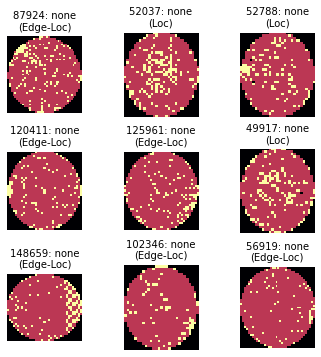

In [15]:
mistakes = [i for i in range(len(same_miss)) if same_miss.iloc[i].failureType == 'none']
random_n = random.sample(mistakes, 9)
plot_list(same_miss, random_n, fig_size=(5,5), col='waferMap', cmap='inferno')

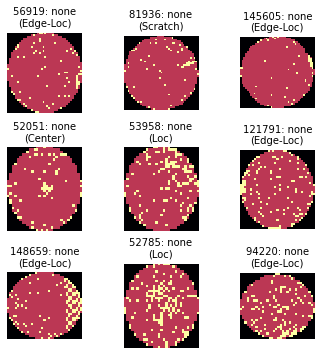

In [22]:
mistakes = [i for i in range(len(same_miss)) if same_miss.iloc[i].failureType == 'none']
random_n = random.sample(mistakes, 9)
plot_list(same_miss, random_n, fig_size=(5,5), col='waferMap', cmap='inferno')

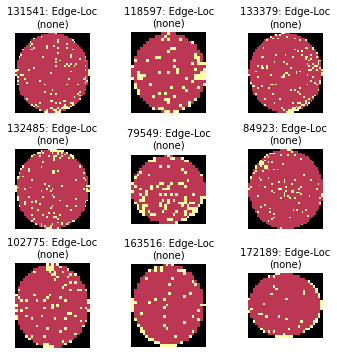

In [23]:
mistakes = [i for i in range(len(same_miss)) 
            if same_miss.iloc[i].failureType == 'Edge-Loc' and same_miss.iloc[i].paper == 8]
random_n = random.sample(mistakes, 9)
plot_list(same_miss, random_n, fig_size=(5,5), col='waferMap', cmap='inferno')

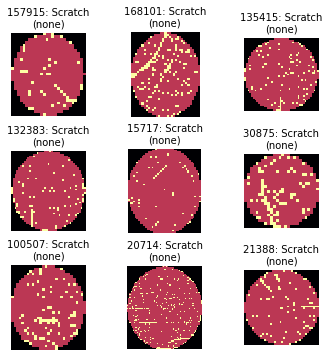

In [20]:
mistakes = [i for i in range(len(same_miss)) 
            if same_miss.iloc[i].failureType == 'Scratch' and same_miss.iloc[i].paper == 8]
random_n = random.sample(mistakes, 9)
plot_list(same_miss, random_n, fig_size=(5,5), col='waferMap', cmap='inferno')

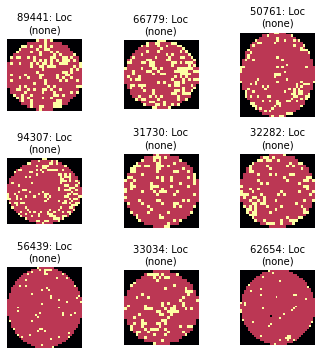

In [24]:
mistakes = [i for i in range(len(same_miss)) 
            if same_miss.iloc[i].failureType == 'Loc' and same_miss.iloc[i].paper == 8]
random_n = random.sample(mistakes, 9)
plot_list(same_miss, random_n, fig_size=(5,5), col='waferMap', cmap='inferno')